# _Are You The One?_ Season One Simulation and Analysis
> Melanie Gutzmann ([@mirrorkeydev](https://github.com/mirrorkeydev)) 12/2020

## Table of Contents
- [Motivation](#Motivation)
- [Framework](#Framework)
- [Season 1 Episodes](#Season-1-Episodes)
- [Analysis](#Analysis)

## Motivation
_Are You the One?_ (AYTO) is an American reality TV series on MTV. The premise is simple: put 20 people in a house, and tell them if they can correctly figure out all pairs that are "perfect matches" (determined beforehand by the producers and a matchmaking algorithm), they all split a prize of $1 million.

There are two mechanisms by which the contestants can empirically narrow down their search every week:

1. Sending 1 couple to the "Truth Booth", which will reveal whether that couple is or isn't a "perfect match"
2. Sending 10 couples to the "Matching Ceremony", which will reveal the number of couples presented that are perfect matches, but not which ones were correct

The first season of this show (originally aired 2014), was just put on Netflix, and I (an avid enjoyer of trash TV) noticed that the probability of a given couple being a match could be calculated by simulating all possible match configurations. Of course, since those episodes are over 6 years old at this point, someone (Alex Wang), already did this, and has a [blog](http://areuthe.blogspot.com/) in which he's analyzed all 8 seasons.

However, I admittedly don't have the strongest (read: any) knowledge of statistics or simulations, so I didn't completely follow how Alex was generating these probability matrixes in his blog. To help my own understanding, I thought it would be fun to deconstruct exactly how to generate the probabilities of each couple as the first season of AYTO progresses.

## Framework

In season 1, the house is comprised of 10 men and 10 women, each of which are part of exactly one hetero "perfect match". Let's initialize our values, and assign names to help visualize what's going on.

In [1]:
import itertools
from enum import Enum
import math

GROUP_COUNT = 10 # Number of people in each group

class Men(Enum):
    ADAM = 0
    CHRIS_S = 1
    CHRIS_T = 2
    DILLAN = 3
    DRE = 4
    ETHAN = 5
    JOEY = 6
    JOHN = 7
    RYAN = 8
    WESLEY = 9

class Women(Enum):
    AMBER = 0
    ASHLEIGH = 1
    BRITTANY = 2
    COLEYSIA = 3
    JACY = 4
    JESSICA = 5
    KAYLA = 6
    PAIGE = 7
    SHANLEY = 8
    SIMONE = 9

print("The number of possible match permutations is: {}".format(math.factorial(GROUP_COUNT)))

perms_over_time = [('Start', math.factorial(GROUP_COUNT))]

The number of possible match permutations is: 3628800


A permutation represents one possible configuration of all 10 couples; there are over 3 million different ways that the set of 10 couples could be formed. Here's a random sample of a few of those:

In [2]:
import random

men_perms = list(itertools.permutations(range(GROUP_COUNT)))

def print_configurations(perms, rows, is_random=True):
    num_perms = len(perms)
    for i in range(rows):
        print("Configuration", i, end="\n\n")
        for w in Women:
            print("\033[96m" + w.name.center(12), end="")
        print("\033[0m")

        perm = men_perms[random.randint(0, len(perms)-1)] if is_random else men_perms[i]
        for m in perm:
            print("\033[95m" + Men(m).name.center(12), end="")
        print("\033[0m\n")
    print("... and {} more of these\n".format(num_perms-rows))

    return num_perms

num = print_configurations(men_perms, 3)

Configuration 0

   AMBER      ASHLEIGH    BRITTANY    COLEYSIA      JACY      JESSICA      KAYLA       PAIGE      SHANLEY      SIMONE   
   WESLEY       RYAN        ADAM        DRE       CHRIS_S     CHRIS_T      DILLAN       JOEY       ETHAN        JOHN    

Configuration 1

   AMBER      ASHLEIGH    BRITTANY    COLEYSIA      JACY      JESSICA      KAYLA       PAIGE      SHANLEY      SIMONE   
    JOEY       ETHAN      CHRIS_T       ADAM      CHRIS_S       DRE        WESLEY       RYAN        JOHN       DILLAN   

Configuration 2

   AMBER      ASHLEIGH    BRITTANY    COLEYSIA      JACY      JESSICA      KAYLA       PAIGE      SHANLEY      SIMONE   
  CHRIS_S       JOHN       WESLEY      DILLAN      ETHAN      CHRIS_T       RYAN        JOEY        ADAM        DRE     

... and 3628797 more of these



Notice above that the women (cyan) never change position in the list, only the men (purple) are permutated. (We arbitrarily chose the men to be permuted rather than the women. If you permutated both the men and women and joined them all, you'd end up with duplicates.) This is important because it means that in our code, we can essentially only worry about permutations of men, because if a man is at a certain index, it means that he is paired with the woman associated with that index.

Now, we can start applying the conditions revealed in each episode.

## Season 1 Episodes

### Episode 1

#### Truth Booth 1

In this episode, Shanley and Chris T. are sent to the truth booth and are revealed to not be a match.
This means that we can narrow down all permutations of the couples configurations to only contain permutations that don't have Shanley and Chris T matched together.


In [3]:
# As explained above, women are represented by the index in each permutation array.
men_perms = [p for p in men_perms if p[Women.SHANLEY.value] != Men.CHRIS_T.value]

new_num = print_configurations(men_perms, 3)

perms_over_time.append(('TB1', new_num))

print("The above permutations don't contain Shanley matched with Chris T.")
print("We've narrowed down the number of permutations from {} to {}, a reduction of {} or {:.1f}%".format(num, new_num, num-new_num, (num-new_num)/(new_num)*100))

Configuration 0

   AMBER      ASHLEIGH    BRITTANY    COLEYSIA      JACY      JESSICA      KAYLA       PAIGE      SHANLEY      SIMONE   
   DILLAN       JOHN        DRE        WESLEY      ETHAN        RYAN        ADAM      CHRIS_S       JOEY      CHRIS_T   

Configuration 1

   AMBER      ASHLEIGH    BRITTANY    COLEYSIA      JACY      JESSICA      KAYLA       PAIGE      SHANLEY      SIMONE   
    JOHN      CHRIS_S      DILLAN       RYAN        JOEY      CHRIS_T      WESLEY       ADAM       ETHAN        DRE     

Configuration 2

   AMBER      ASHLEIGH    BRITTANY    COLEYSIA      JACY      JESSICA      KAYLA       PAIGE      SHANLEY      SIMONE   
    ADAM       ETHAN        DRE         JOEY      CHRIS_T       RYAN       WESLEY      DILLAN       JOHN      CHRIS_S   

... and 3265917 more of these

The above permutations don't contain Shanley matched with Chris T.
We've narrowed down the number of permutations from 3628800 to 3265920, a reduction of 362880 or 11.1%


So how do we calculate the probability of each couple being a perfect match at this point? We simply count how many permutations are left that contain each couple, and then divide each sum by the amount of total permutations.

In [4]:
def calculate_probabilities(perms):
    pair_sum = [[0 for i in range(GROUP_COUNT)] for j in range(GROUP_COUNT)] # a zeroed two dimensional array

    # Do the counting
    for perm in perms:
        for woman, man in enumerate(perm):
            pair_sum[woman][man] += 1

    return [[pair / sum(pairs) for pair in pairs] for pairs in pair_sum]

def print_probabilities(perms):
    probabilities = calculate_probabilities(perms)
    print("".center(12), end='')
    for m in Men:
        print("\033[95m\033[1m" + f'{m.name}'.center(12), end='')
    print("\033[0m")
    for woman, prob_row in enumerate(probabilities):
        print('\033[96m\033[1m' + f'{Women(woman).name}'.rjust(12) + '\033[0m', end='')
        for prob_val in prob_row:
            if prob_val*100 >= 100:
                print("\033[92m" + 'MATCH'.center(12) + "\033[0m", end='')
            elif not prob_val:
                print("\033[91m" + 'X'.center(12) + "\033[0m", end='')
            elif prob_val == max(prob_row):
                print("\033[92m" + f'{prob_val*100:2.1f}%'.center(12) + "\033[0m", end='')
            elif prob_val*100 > 20:
                print("\033[93m" + f'{prob_val*100:2.1f}%'.center(12) + "\033[0m", end='')
            else:
                print("\033[0m" + f'{prob_val*100:2.1f}%'.center(12) + "\033[0m", end='')
        print()
    print()

print_probabilities(men_perms)

                ADAM      CHRIS_S     CHRIS_T      DILLAN       DRE        ETHAN        JOEY        JOHN        RYAN       WESLEY   
       AMBER    9.9%        9.9%       11.1%        9.9%        9.9%        9.9%        9.9%        9.9%        9.9%        9.9%    
    ASHLEIGH    9.9%        9.9%       11.1%        9.9%        9.9%        9.9%        9.9%        9.9%        9.9%        9.9%    
    BRITTANY    9.9%        9.9%       11.1%        9.9%        9.9%        9.9%        9.9%        9.9%        9.9%        9.9%    
    COLEYSIA    9.9%        9.9%       11.1%        9.9%        9.9%        9.9%        9.9%        9.9%        9.9%        9.9%    
        JACY    9.9%        9.9%       11.1%        9.9%        9.9%        9.9%        9.9%        9.9%        9.9%        9.9%    
     JESSICA    9.9%        9.9%       11.1%        9.9%        9.9%        9.9%        9.9%        9.9%        9.9%        9.9%    
       KAYLA    9.9%        9.9%       11.1%        9.9%        9.9% 

#### Match Ceremony 1

At the end of the week, a Match Ceremony occurs. At this point, all the contestants know is that it's not Christ T. and Shanley, so they pair up pretty randomly.

| Men       | Women    |
|-----------|----------|
| Wesley    | Kayla    |
| Ethan     | Shanley  |
| Adam      | Brittany |
| Dre       | Jacy     |
| John      | Simone   |
| Chris T.  | Jessica  |
| Joey      | Paige    |
| Chris S.  | Ashleigh |
| Ryan      | Amber    |
| Dillan    | Coleysia |

The Match Ceremony reveals that two of these couples are correct. So how does that affect the probability of all of the couples?

To narrow down our list of permutations, we want to _only select the permutations that contain exactly two couples from the Match Ceremony._



> If it's not quite clear why we do this, consider an example:
>
> Couples `Anya` + `Aaron`, `Brooklyn` + `Brook`, and `Carly` + `Charlie` go to the Match Ceremony, which returns that one of the couples are a perfect match. Our total list of permutations for these couples is:
>
>| Permutations|
>|-------------|
>|A+A, B+B, C+C|
>|A+A, B+C, C+B|
>|A+B, B+A, C+C|
>|A+B, B+C, C+A|
>|A+C, B+A, C+B|
>|A+C, B+B, C+A|
>    
>Very clearly, we can eliminate permutation 1, since it's what we just tested at the ceremony, and it only returned 1 couple as a perfect match. However, we can also eliminate permutations 4 and 5, since they don't contain a single couple from the set that we sent to the Match Ceremony. It would be impossible for those permutations to be the winning configuration, because one of the couples we just tested has to be a winner.
>
>| Permutations|
>|-------------|
>|~~A+A, B+B, C+C~~|
>|**A+A**, B+C, C+B|
>|A+B, B+A, **C+C**|
>|~~A+B, B+C, C+A~~|
>|~~A+C, B+A, C+B~~|
>|A+C, **B+B**, C+A|
>
>Each of the remaining permutations contains exactly one couple from the Match Ceremony; through a single ceremony, we were able to reduce the number of permutations by half. Since our example is pretty contrived, we weren't actually able to reduce the probabiity of any single couple (all couples are still equally likely to be correct, just not at the same time), but it's a good example of how you can eliminate combinations of couples: for example, we know now that `Anya` and `Brooklyn` cannot be a couple at the same time as `Brook` and `Charlie` (permutation 4).

So let's apply the Match Ceremony's results to our couples:

In [5]:
# Determines if a given permutation has exactly match_count couples in it
# from the matching ceremony.
def valid_perm(perm, matches, match_count):   
    for permMan, matchMan in zip(perm, matches):
        if permMan == matchMan:
            match_count -= 1
            if match_count < 0:
                return False
    return match_count == 0

# The women are the indexes:         Amber     Ashleigh    Brittany   Coleysia   Jacy     Jessica       Kayla      Paige     Shanley    Simone
matches = tuple([x.value for x in (Men.RYAN, Men.CHRIS_S, Men.ADAM, Men.DILLAN, Men.DRE, Men.CHRIS_T, Men.WESLEY, Men.JOEY, Men.ETHAN, Men.JOHN)])
correct_match_count = 2

men_perms = [p for p in men_perms if valid_perm(p, matches, correct_match_count)]

perms_over_time.append(('MC1', len(men_perms)))

print_probabilities(men_perms)
print("We've narrowed down the number of permutations from {} to {}, a reduction of {} or {:.1f}%".format(new_num, len(men_perms), new_num-len(men_perms), (new_num-len(men_perms))/(len(men_perms))*100))

                ADAM      CHRIS_S     CHRIS_T      DILLAN       DRE        ETHAN        JOEY        JOHN        RYAN       WESLEY   
       AMBER    8.9%        8.9%        9.8%        8.9%        8.9%        8.7%        8.9%        8.9%       19.5%        8.9%    
    ASHLEIGH    8.9%       19.5%        9.8%        8.9%        8.9%        8.7%        8.9%        8.9%        8.9%        8.9%    
    BRITTANY   19.5%        8.9%        9.8%        8.9%        8.9%        8.7%        8.9%        8.9%        8.9%        8.9%    
    COLEYSIA    8.9%        8.9%        9.8%       19.5%        8.9%        8.7%        8.9%        8.9%        8.9%        8.9%    
        JACY    8.9%        8.9%        9.8%        8.9%       19.5%        8.7%        8.9%        8.9%        8.9%        8.9%    
     JESSICA    8.7%        8.7%       22.0%        8.7%        8.7%        8.5%        8.7%        8.7%        8.7%        8.7%    
       KAYLA    8.9%        8.9%        9.8%        8.9%        8.9% 

From this, we can see that some couple combinations are now twice as likely to be correct than guessing randomly.

### Episode 2
#### Truth Booth 2

Ethan and Jessica are not a match.

In [6]:
men_perms = [p for p in men_perms if p[Women.JESSICA.value] != Men.ETHAN.value]

print_probabilities(men_perms)
perms_over_time.append(('TB2', len(men_perms)))
print(f"Number of permutations left: {len(men_perms)}")

                ADAM      CHRIS_S     CHRIS_T      DILLAN       DRE        ETHAN        JOEY        JOHN        RYAN       WESLEY   
       AMBER    8.9%        8.9%        9.5%        8.9%        8.9%        9.5%        8.9%        8.9%       19.0%        8.9%    
    ASHLEIGH    8.9%       19.0%        9.5%        8.9%        8.9%        9.5%        8.9%        8.9%        8.9%        8.9%    
    BRITTANY   19.0%        8.9%        9.5%        8.9%        8.9%        9.5%        8.9%        8.9%        8.9%        8.9%    
    COLEYSIA    8.9%        8.9%        9.5%       19.0%        8.9%        9.5%        8.9%        8.9%        8.9%        8.9%    
        JACY    8.9%        8.9%        9.5%        8.9%       19.0%        9.5%        8.9%        8.9%        8.9%        8.9%    
     JESSICA    9.5%        9.5%       24.0%        9.5%        9.5%         X          9.5%        9.5%        9.5%        9.5%    
       KAYLA    8.9%        8.9%        9.5%        8.9%        8.9% 

#### Match Ceremony 2

| Men       | Women    |
|-----------|----------|
| Wesley    | Coleysia |
| Ethan     | Amber    |
| Adam      | Shanley  |
| Dre       | Ashleigh |
| John      | Jacy     |
| Christ T. | Paige    |
| Joey      | Brittany |
| Chris S.  | Simone   |
| Ryan      | Kayla    |
| Dillan    | Jessica  |

4 couples are correct.


In [7]:
# The women are the indexes:         Amber   Ashleigh  Brittany  Coleysia       Jacy     Jessica     Kayla      Paige     Shanley     Simone
matches = tuple([x.value for x in (Men.ETHAN, Men.DRE, Men.JOEY, Men.WESLEY, Men.JOHN, Men.DILLAN, Men.RYAN, Men.CHRIS_T, Men.ADAM, Men.CHRIS_S)])
correct_match_count = 4

men_perms = [p for p in men_perms if valid_perm(p, matches, correct_match_count)]

print_probabilities(men_perms)
perms_over_time.append(('MC2', len(men_perms)))
print(f"Number of permutations left: {len(men_perms)}")

                ADAM      CHRIS_S     CHRIS_T      DILLAN       DRE        ETHAN        JOEY        JOHN        RYAN       WESLEY   
       AMBER    5.2%        5.0%        5.1%        4.6%        5.0%       40.9%        5.2%        5.0%       19.0%        5.1%    
    ASHLEIGH    4.9%       20.0%        5.2%        5.0%       39.1%        5.2%        5.0%        5.4%        5.1%        5.0%    
    BRITTANY   18.9%        5.0%        5.4%        5.2%        5.0%        5.4%       39.9%        5.0%        5.1%        5.2%    
    COLEYSIA    5.1%        5.1%        5.5%       19.0%        5.1%        5.5%        5.1%        5.1%        5.2%       39.3%    
        JACY    4.9%        5.4%        5.2%        5.0%       20.0%        5.2%        5.0%       39.1%        5.1%        5.0%    
     JESSICA    4.9%        5.2%       22.2%       40.9%        5.2%         X          5.4%        5.2%        5.5%        5.3%    
       KAYLA    5.1%        5.0%        5.1%        5.1%        5.0% 

### Episode 3
#### Truth Booth 3

John and Simone are not a match.

In [8]:
men_perms = [p for p in men_perms if p[Women.SIMONE.value] != Men.JOHN.value]

print_probabilities(men_perms)
perms_over_time.append(('TB3', len(men_perms)))
print(f"Number of permutations left: {len(men_perms)}")

                ADAM      CHRIS_S     CHRIS_T      DILLAN       DRE        ETHAN        JOEY        JOHN        RYAN       WESLEY   
       AMBER    5.3%        3.9%        5.1%        4.6%        5.0%       38.2%        5.1%        6.2%       21.5%        5.1%    
    ASHLEIGH    4.9%       20.9%        5.1%        5.0%       37.1%        5.2%        5.0%        6.8%        5.1%        5.0%    
    BRITTANY   21.4%        3.9%        5.4%        5.1%        5.0%        5.4%       37.6%        6.3%        4.9%        5.0%    
    COLEYSIA    5.1%        3.9%        5.5%       21.5%        5.1%        5.4%        4.9%        6.4%        5.2%       37.0%    
        JACY    3.9%        2.9%        4.0%        3.9%       20.9%        4.0%        3.9%       48.9%        3.9%        3.9%    
     JESSICA    4.8%        4.0%       25.0%       38.2%        5.2%         X          5.4%        6.6%        5.4%        5.3%    
       KAYLA    5.1%        3.9%        5.0%        5.1%        5.0% 

#### Match Ceremony 3


In [9]:
# The women are the indexes:         Amber   Ashleigh  Brittany  Coleysia       Jacy     Jessica     Kayla      Paige     Shanley     Simone
matches = tuple([x.value for x in (Men.ETHAN, Men.DRE, Men.ADAM, Men.DILLAN, Men.WESLEY, Men.JOHN, Men.RYAN, Men.CHRIS_S, Men.JOEY, Men.CHRIS_T)])
correct_match_count = 2

men_perms = [p for p in men_perms if valid_perm(p, matches, correct_match_count)]

print_probabilities(men_perms)
perms_over_time.append(('MC3', len(men_perms)))
print(f"Number of permutations left: {len(men_perms)}")

                ADAM      CHRIS_S     CHRIS_T      DILLAN       DRE        ETHAN        JOEY        JOHN        RYAN       WESLEY   
       AMBER    4.8%        4.8%        4.9%        4.1%        4.5%       44.0%        6.0%        5.7%       14.3%        7.0%    
    ASHLEIGH    3.7%       19.6%        5.3%        4.4%       41.1%        3.7%        5.4%        6.4%        4.9%        5.5%    
    BRITTANY   25.3%        4.2%        5.0%        6.0%        4.2%        5.4%       33.4%        6.2%        4.8%        5.6%    
    COLEYSIA    5.8%        4.5%        4.7%       25.7%        4.2%        4.5%        5.4%        5.4%        4.7%       35.2%    
        JACY    3.9%        3.0%        3.2%        4.6%       19.4%        4.4%        3.9%       51.4%        4.3%        1.9%    
     JESSICA    4.6%        4.2%       26.7%       32.1%        6.0%         X          6.1%        6.6%        6.6%        7.0%    
       KAYLA    4.6%        4.1%        5.0%        4.4%        3.5% 

### Episode 4
#### Truth Booth 4

Dillan and Jessica are not a match.


In [10]:
men_perms = [p for p in men_perms if p[Women.JESSICA.value] != Men.DILLAN.value]

print_probabilities(men_perms)
perms_over_time.append(('TB4', len(men_perms)))
print(f"Number of permutations left: {len(men_perms)}")

                ADAM      CHRIS_S     CHRIS_T      DILLAN       DRE        ETHAN        JOEY        JOHN        RYAN       WESLEY   
       AMBER    5.8%        4.0%        4.3%        6.0%        3.7%       47.4%        5.6%        4.6%       11.8%        6.9%    
    ASHLEIGH    4.4%       17.5%        4.1%        6.5%       42.2%        3.4%        5.0%        6.1%        4.8%        6.0%    
    BRITTANY   13.2%        4.1%        3.8%        8.8%        4.8%        6.5%       41.9%        5.2%        5.3%        6.3%    
    COLEYSIA    4.7%        3.7%        2.2%       37.8%        2.9%        2.7%        4.1%        4.2%        3.6%       34.1%    
        JACY    4.2%        2.6%        1.7%        6.8%       18.1%        4.0%        2.7%       55.3%        3.9%        0.8%    
     JESSICA    6.8%        6.1%       39.4%         X          8.9%         X          9.0%        9.7%        9.8%       10.3%    
       KAYLA    5.3%        3.2%        4.4%        6.5%        3.1% 

#### Match Ceremony 4

Again, only 2 are correct. However, because they chose distinct couples (for the most part) that hadn't been seen before, they managed to eliminate a lot of possible pairings (Coleysia with Chris S., Dre, and Ethan, as well as Shanley with Joey and Chris. T).

In [11]:
# The women are the indexes:         Amber   Ashleigh     Brittany  Coleysia      Jacy     Jessica      Kayla      Paige      Shanley    Simone
matches = tuple([x.value for x in (Men.ADAM, Men.CHRIS_T, Men.RYAN, Men.DILLAN, Men.JOEY, Men.WESLEY, Men.ETHAN, Men.CHRIS_S, Men.JOHN, Men.DRE)])
correct_match_count = 2

men_perms = [p for p in men_perms if valid_perm(p, matches, correct_match_count)]

print_probabilities(men_perms)
perms_over_time.append(('MC4', len(men_perms)))
print(f"Number of permutations left: {len(men_perms)}")

                ADAM      CHRIS_S     CHRIS_T      DILLAN       DRE        ETHAN        JOEY        JOHN        RYAN       WESLEY   
       AMBER   14.1%        5.6%        5.6%        0.7%        2.8%       41.5%        4.2%        3.5%       12.7%        9.2%    
    ASHLEIGH    6.3%       14.8%       12.0%        0.7%       35.9%        5.6%        3.5%        7.7%        7.0%        6.3%    
    BRITTANY    1.4%        2.8%        3.5%        5.6%        5.6%        6.3%       52.1%        4.2%       13.4%        4.9%    
    COLEYSIA    0.7%         X          1.4%       81.7%         X           X          0.7%        1.4%        0.7%       13.4%    
        JACY    2.8%        1.4%        0.7%        3.5%       15.5%        2.8%        5.6%       62.7%        4.2%        0.7%    
     JESSICA    7.7%        5.6%       22.5%         X          8.5%         X         10.6%        2.8%       12.7%       29.6%    
       KAYLA    7.0%        3.5%        5.6%        2.1%        3.5% 

### Episode 5
#### Truth Booth 5
Dre and Ashleigh aren't a match.

In [12]:
men_perms = [p for p in men_perms if p[Women.ASHLEIGH.value] != Men.DRE.value]

print_probabilities(men_perms)
perms_over_time.append(('TB5', len(men_perms)))
print(f"Number of permutations left: {len(men_perms)}")

                ADAM      CHRIS_S     CHRIS_T      DILLAN       DRE        ETHAN        JOEY        JOHN        RYAN       WESLEY   
       AMBER    8.8%        4.4%        5.5%        1.1%        4.4%       61.5%        4.4%        1.1%        1.1%        7.7%    
    ASHLEIGH    9.9%       23.1%       18.7%        1.1%         X          8.8%        5.5%       12.1%       11.0%        9.9%    
    BRITTANY     X          2.2%        2.2%        4.4%        8.8%        5.5%       59.3%        4.4%        9.9%        3.3%    
    COLEYSIA    1.1%         X          1.1%       85.7%         X           X           X          1.1%        1.1%        9.9%    
        JACY    3.3%        1.1%         X          2.2%       24.2%         X          4.4%       60.4%        3.3%        1.1%    
     JESSICA    9.9%        4.4%       16.5%         X         13.2%         X          7.7%        4.4%       12.1%       31.9%    
       KAYLA    4.4%        3.3%        6.6%        1.1%        5.5% 

#### Truth Booth 6

Coleysia and Dillan are a match!

In [13]:
men_perms = [p for p in men_perms if p[Women.COLEYSIA.value] == Men.DILLAN.value]

print_probabilities(men_perms)
perms_over_time.append(('TB6', len(men_perms)))
print(f"Number of permutations left: {len(men_perms)}")

                ADAM      CHRIS_S     CHRIS_T      DILLAN       DRE        ETHAN        JOEY        JOHN        RYAN       WESLEY   
       AMBER    7.7%        5.1%        6.4%         X          5.1%       59.0%        5.1%        1.3%        1.3%        9.0%    
    ASHLEIGH   10.3%       17.9%       16.7%         X           X         10.3%        6.4%       14.1%       12.8%       11.5%    
    BRITTANY     X          2.6%        2.6%         X         10.3%        6.4%       60.3%        3.8%       10.3%        3.8%    
    COLEYSIA     X           X           X         MATCH         X           X           X           X           X           X      
        JACY    2.6%        1.3%         X           X         21.8%         X          2.6%       66.7%        3.8%        1.3%    
     JESSICA   10.3%        5.1%       11.5%         X         15.4%         X          9.0%        1.3%       14.1%       33.3%    
       KAYLA    5.1%        3.8%        7.7%         X          6.4% 

#### Match Ceremony 5

The contestants have no way of knowing this, but Simone and Chris S. have already been eliminated as a possible match, so sending them to the ceremony is pointless.

In [14]:
# The women are the indexes:         Amber   Ashleigh   Brittany  Coleysia     Jacy     Jessica      Kayla      Paige      Shanley     Simone
matches = tuple([x.value for x in (Men.ETHAN, Men.RYAN, Men.DRE, Men.DILLAN, Men.JOHN, Men.JOEY, Men.WESLEY, Men.CHRIS_T, Men.ADAM, Men.CHRIS_S)])
correct_match_count = 5

men_perms = [p for p in men_perms if valid_perm(p, matches, correct_match_count)]

print_probabilities(men_perms)
perms_over_time.append(('MC5', len(men_perms)))
print(f"Number of permutations left: {len(men_perms)}")

                ADAM      CHRIS_S     CHRIS_T      DILLAN       DRE        ETHAN        JOEY        JOHN        RYAN       WESLEY   
       AMBER     X           X          4.2%         X           X         79.2%        8.3%         X           X          8.3%    
    ASHLEIGH   16.7%       16.7%       29.2%         X           X          4.2%        4.2%        8.3%       12.5%        8.3%    
    BRITTANY     X           X           X           X         12.5%        4.2%       58.3%         X         16.7%        8.3%    
    COLEYSIA     X           X           X         MATCH         X           X           X           X           X           X      
        JACY     X          4.2%         X           X          8.3%         X           X         75.0%       12.5%         X      
     JESSICA    8.3%       12.5%       12.5%         X         20.8%         X          4.2%        4.2%       20.8%       16.7%    
       KAYLA     X          4.2%        8.3%         X          8.3% 

### Episode 6
#### Truth Booth 7
Chris T. and Paige are a match!

In [15]:
men_perms = [p for p in men_perms if p[Women.PAIGE.value] == Men.CHRIS_T.value]

print_probabilities(men_perms)
perms_over_time.append(('TB7', len(men_perms)))
print(f"Number of permutations left: {len(men_perms)}")

                ADAM      CHRIS_S     CHRIS_T      DILLAN       DRE        ETHAN        JOEY        JOHN        RYAN       WESLEY   
       AMBER     X           X           X           X           X         63.6%       18.2%         X           X         18.2%    
    ASHLEIGH   36.4%       36.4%         X           X           X           X           X         18.2%        9.1%         X      
    BRITTANY     X           X           X           X         18.2%        9.1%       54.5%         X          9.1%        9.1%    
    COLEYSIA     X           X           X         MATCH         X           X           X           X           X           X      
        JACY     X          9.1%         X           X          9.1%         X           X         63.6%       18.2%         X      
     JESSICA     X         18.2%         X           X         18.2%         X          9.1%        9.1%       27.3%       18.2%    
       KAYLA     X           X           X           X           X   

### Episode 7
#### Match Ceremony 6

Again, we already know Shanley + Dre, Brittany + Chris S., and Simone + Joey can't be a match, but they are sent to the ceremony anyway.

In [16]:
# The women are the indexes:         Amber   Ashleigh    Brittany     Coleysia     Jacy     Jessica     Kayla      Paige      Shanley    Simone
matches = tuple([x.value for x in (Men.ETHAN, Men.ADAM, Men.CHRIS_S, Men.DILLAN, Men.JOHN, Men.RYAN, Men.WESLEY, Men.CHRIS_T, Men.DRE, Men.JOEY)])
correct_match_count = 5

men_perms = [p for p in men_perms if valid_perm(p, matches, correct_match_count)]

print_probabilities(men_perms)
print_configurations(men_perms, 3, False)
perms_over_time.append(('MC6', len(men_perms)))
print(f"Number of permutations left: {len(men_perms)}")

                ADAM      CHRIS_S     CHRIS_T      DILLAN       DRE        ETHAN        JOEY        JOHN        RYAN       WESLEY   
       AMBER     X           X           X           X           X         MATCH         X           X           X           X      
    ASHLEIGH   33.3%       33.3%         X           X           X           X           X         33.3%         X           X      
    BRITTANY     X           X           X           X           X           X         66.7%         X           X         33.3%    
    COLEYSIA     X           X           X         MATCH         X           X           X           X           X           X      
        JACY     X         33.3%         X           X           X           X           X         33.3%       33.3%         X      
     JESSICA     X           X           X           X         33.3%         X           X           X         66.7%         X      
       KAYLA     X           X           X           X           X   

### Episode 8 (Finale)
#### Match Ceremony 7

There's only 3 permutations left, and the contestants have 3 more attempts left to win the prize, so it's pretty clear they're going to succeed.


In [17]:
# The women are the indexes:         Amber    Ashleigh   Brittany  Coleysia     Jacy        Jessica     Kayla      Paige      Shanley    Simone
matches = tuple([x.value for x in (Men.ETHAN, Men.RYAN, Men.JOHN, Men.DILLAN, Men.CHRIS_S, Men.JOEY, Men.WESLEY, Men.CHRIS_T, Men.ADAM, Men.DRE)])
correct_match_count = 7

men_perms = [p for p in men_perms if valid_perm(p, matches, correct_match_count)]

print_probabilities(men_perms)
perms_over_time.append(('MC7', len(men_perms)))
print(f"Number of permutations left: {len(men_perms)}")

                ADAM      CHRIS_S     CHRIS_T      DILLAN       DRE        ETHAN        JOEY        JOHN        RYAN       WESLEY   
       AMBER     X           X           X           X           X         MATCH         X           X           X           X      
    ASHLEIGH     X           X           X           X           X           X           X         MATCH         X           X      
    BRITTANY     X           X           X           X           X           X         MATCH         X           X           X      
    COLEYSIA     X           X           X         MATCH         X           X           X           X           X           X      
        JACY     X         MATCH         X           X           X           X           X           X           X           X      
     JESSICA     X           X           X           X           X           X           X           X         MATCH         X      
       KAYLA     X           X           X           X           X   

And indeed, they don't guess correctly (only 7/10), but it's enough to narrow down the number of permutations to 1, so they're easily able to secure the win.

## Analysis

We've been keeping track of the number of permutations at each step of this process, so lets visualize them.

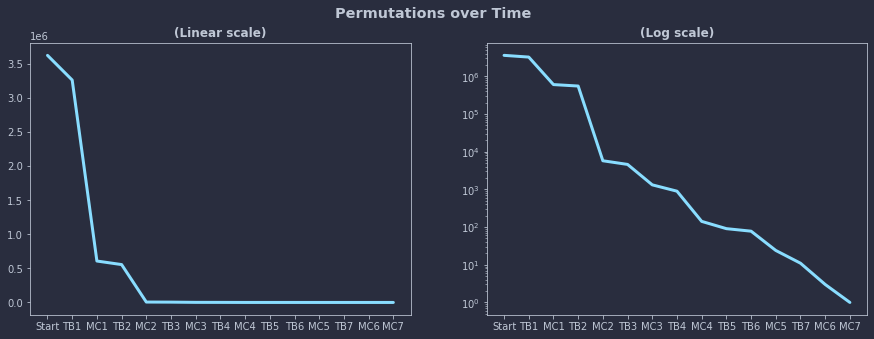

In [18]:
import matplotlib
from matplotlib import pyplot as plt

# Isn't read correctly from the matplotlibrc, so need to manually set
matplotlib.rcParams["figure.facecolor"] = '#292d3e'

# Plotting!
plt.figure(figsize=(15, 5))
plt.suptitle('Permutations over Time ')
plt.subplot(121)
plt.plot([x[0] for x in perms_over_time], [x[1] for x in perms_over_time])
plt.gca().set_title('(Linear scale)')
plt.subplot(122)
plt.plot([x[0] for x in perms_over_time], [x[1] for x in perms_over_time])
plt.gca().set_title('(Log scale)')
plt.yscale('log') 

plt.show()

As you can see, the [first Match Ceremony](#Match-Ceremony-1) dropped the number of permutations by around 2.5 million, by far the largest decrease in the entire season.